# AdaBoost 

Adaptive Boosting is an iterative sequence of weak algorithms, typically decision trees. The classifier starts with a base decision tree model and each subsequent model iteratively learns from the mistakes of its predecessor and updates the weights and biases of the instances that were misclassified.


# Training Process

The algorithm starts with an initial base model and makes predictions with equal weights for all features. The instances misclassified by this base model are boosted and the subsequent model then performs better than its predecessor. This sequence continues until all predictors are trained. The model then makes predictions by using the class that receives the majority of the weighted votes across all models.

There are notable differences between Random Forests and Adaboost. When making predictions, random forests apply an equal vote to all trees in the ensemble while Adaboost applies greater weights to trees that minimize the error rate. Moreover, Adaboost operates by training the model sequentially where each tree is fit on a modified version of the original dataset. while Random Forests apply bagging based resampling technique in a parallel fashion. 

# AdaBoost Hyperparameters


- n_estimators : The number of trees.

- learning_rate: Weight applied to each model at each boosting iteration

- algorithm: If model supports probabilistic output use 'SAMME.R' if model produces discreet output 1/0 use  'SAMME'.



# AdaBoost Pros and Cons


**Pros**

- Very few hyperparameters for tune.

- They are non- parametric models and don’t require data-pre-processing (feature scaling or one-hot-encoding)

- Good for non-linear datasets


**Cons**


- Cannot be parallelized as each model is trained based on the results of the previous model.

- Much slower than other boosting models such as XGboost




# 1. Libraries

In [3]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [4]:
# Import Data
dataset = pd.read_csv('Social_Network_Ads.csv')
dataset.head()

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0


# 2. Preprocessing

In [5]:
# Create subsets of input features and response variable.
X = dataset.iloc[:, :-1].values
y = dataset['Purchased'].values

# Training and Testing subsets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 911)

# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print('Standardized feature Mean:',  X_train.mean().round())
print('Standardized feature SD :',   X_train.std().round())

Standardized feature Mean: 0.0
Standardized feature SD : 1.0


# 3. Training

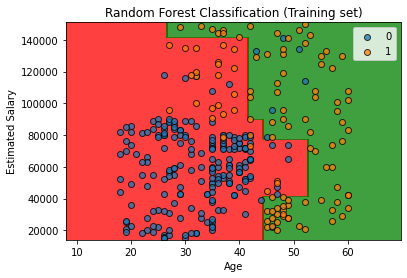

In [29]:
# Initialize AdaBoost Classifier
ada = AdaBoostClassifier(
 DecisionTreeClassifier(max_depth=1), n_estimators=10,
 algorithm="SAMME.R", learning_rate=0.5)

# Fit the model
ada.fit(X_train, y_train)

# Visualise the Training results
X_set, y_set = sc.inverse_transform(X_train), y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 10, stop = X_set[:, 0].max() + 10, step = 0.25),
                     np.arange(start = X_set[:, 1].min() - 1000, stop = X_set[:, 1].max() + 1000, step = 0.25))
plt.contourf(X1, X2, ada.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], cmap = ListedColormap(('red', 'green'))(i),edgecolor = 'black',
            linewidth = 1,
            alpha = 0.75, label = j)
plt.title('AdaBoost Classification (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

# 3. Testing

In [10]:
# Predicting a new result using age 40 and salary 87000
print(ada.predict(sc.transform([[40,87000]])))
ada.predict_proba(sc.transform([[40,87000]]))

# Predicting the Test set results
y_pred = ada.predict(X_test)

# Classification Accuracy
print('Classification Accuracy :', accuracy_score(y_test, y_pred))

[0]
Classification Accuracy : 0.8125


# 4. K-Fold Cross Validation

In [49]:
# 10 fold cross validation
accuracies = cross_val_score(estimator = ada,
                             X = X,
                             y = y,
                             cv = 10,
                             scoring = 'accuracy')

# Cross validation accuracy and standard deviation
print(accuracies)
print("Accuracy: {:.3f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.3f} %".format(accuracies.std()*100))

[0.975 0.725 0.95  0.95  1.    0.9   0.75  0.775 0.875 0.9  ]
Accuracy: 88.000 %
Standard Deviation: 9.274 %


# 5. Hyperparametric Tuning

In [50]:
# Grid Search CV
ada = AdaBoostClassifier()
param_grid = [{
      'learning_rate': [0.25, 0.5, 1],
      'n_estimators': [10, 100, 1000],
      'algorithm': ['SAMME', 'SAMME.R']}]


# Configure GridSearchCV
grid_search = GridSearchCV(ada, param_grid, cv=5,
                                  scoring="accuracy",
                                  n_jobs=-1)

# Initiate Search
grid_search.fit(X_train, y_train)

# Extract Tuned Parameters and Predictive Accuracy
tuned_params = grid_search.best_params_
tuned_score = grid_search.best_score_
best_estimator = grid_search.best_estimator_

# Print Results
print("Best Accuracy: {:.2f} %".format(grid_search.best_score_*100))
print("Best Parameters:", tuned_params)

Best Accuracy: 91.56 %
Best Parameters: {'algorithm': 'SAMME', 'learning_rate': 0.5, 'n_estimators': 100}


In [41]:
# Randomized Search

ada = AdaBoostClassifier()
param_grid = [{
      'learning_rate': [0.25, 0.5, 1, 2],
      'n_estimators': [10, 100, 1000],
      'algorithm': ['SAMME', 'SAMME.R']}]


# Configure Randomized Search
random_search = RandomizedSearchCV(ada, param_grid, n_iter=24,
                                        scoring="accuracy", cv=5,
                                        n_jobs=-1, random_state=911)
#Initiate Search
random_search.fit(X_train, y_train)


# Extract Tuned Parameters and Predictive Accuracy
tuned_params = random_search.best_params_
tuned_score = random_search.best_score_
best_estimator = random_search.best_estimator_

# Print accuracy and best parameters
print("Best Accuracy: {:.2f} %".format(random_search.best_score_*100))
print("Best Parameters:", tuned_params)

Best Accuracy: 91.56 %
Best Parameters: {'n_estimators': 100, 'learning_rate': 0.5, 'algorithm': 'SAMME'}


# 6. Evaluation Metrics

In [46]:
# Confusion Matrix/AUC/Classification Report 

def evaluate_model(ada, X_test):
    
    y_pred = random_search.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    clr = classification_report(y_test, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.6, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.6, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)
    
    
    # ROC/AUC Curve
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, c = 'green', linewidth = 3, alpha = 0.75)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.show()
    
    
    # Visualising the Testing Results
    X_set, y_set = sc.inverse_transform(X_test), y_test
    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 10, stop = X_set[:, 0].max() + 10, step = 0.25),
                         np.arange(start = X_set[:, 1].min() - 1000, stop = X_set[:, 1].max() + 1000, step = 0.25))
    plt.contourf(X1, X2, rf.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
                 alpha = 0.75, cmap = ListedColormap(('red', 'green')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], cmap = ListedColormap(('red', 'green'))(i),edgecolor = 'black',
            linewidth = 1,
            alpha = 0.75, label = j)
    plt.title('AdaBoost Decision Boundry (Test set)')
    plt.xlabel('Age')
    plt.ylabel('Estimated Salary')
    plt.legend()
    plt.show()

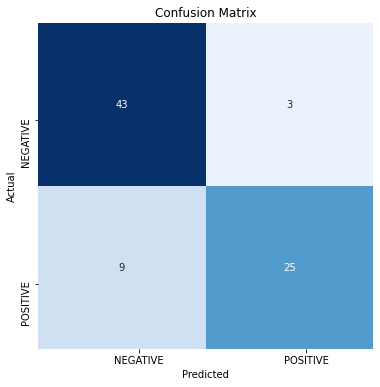

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.83      0.93      0.88        46
    POSITIVE       0.89      0.74      0.81        34

    accuracy                           0.85        80
   macro avg       0.86      0.84      0.84        80
weighted avg       0.85      0.85      0.85        80



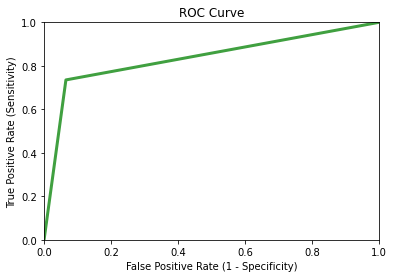

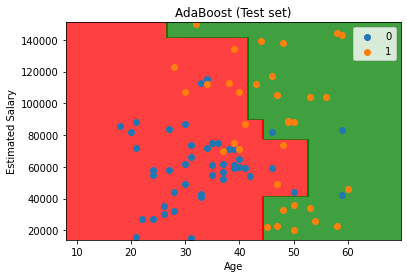

In [47]:
evaluate_model(ada, X_test)